## Multiclass Text classification -
##Name -  Sinjini Bose


In [470]:

## please uncomment pip install to install required packages
#!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

#### for reading PDFs ###
#!pip install pdfminer
import io 
import pdfminer
from pdfminer.converter import TextConverter 
from pdfminer.pdfinterp import PDFPageInterpreter 
from pdfminer.pdfinterp import PDFResourceManager 
from pdfminer.pdfpage import PDFPage

#### for reading DOCxs ###
#!pip install python-docx
import docx

### for Dataframe related operation
import pandas as pd
import numpy as np


### for text preprocessing
#!pip install stanza
import stanza

### for creating word embeddings and vectorizing documents
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
import gensim.downloader as gensim_api


### for modeling purposes
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import  make_scorer,accuracy_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as  sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### for sampling imbalanced dataset
from imblearn.over_sampling import SMOTE
### for saving model files and feature matrixes
import pickle


###Connecting Google Drive to Colab, to fetch the folders

In [ ]:
auth.authenticate_user()
gAuth = GoogleAuth()
gAuth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gAuth)

In [ ]:
colab_path = os.path.expanduser('~/data3')
os.makedirs(colab_path)

In [ ]:
file_list = drive.ListFile(
    {'q': "'1_OjKCTCVUE0-x2fg2fYwLXy_LI5I_U3L' in parents"}).GetList()


In [ ]:
file_list_litigations = drive.ListFile({'q':"'1w9R9jdsj1Mj_6POSQTK66EmfF8OntqRg' in parents" }).GetList()
file_list_agreements = drive.ListFile({'q':"'1iwY83fjZLhOmmctIumzgJ8yGUaRT4RBL' in parents" }).GetList()
file_list_taxes = drive.ListFile({'q':"'1up01ltb1_H7nBccqQAMomPuMfTQA38b9' in parents" }).GetList()
file_list_human_resources = drive.ListFile({'q':"'1Ef55RK3EOsjE1iDVqukVW6zJH2XSyGkt' in parents" }).GetList()
file_list_deeds = drive.ListFile({'q':"'1iUOjuoWk0UqXiTPZNNQ0Qsfmhr__5_A8' in parents" }).GetList()
file_list_valuations = drive.ListFile({'q':"'1-jMO2AtZ5qZpYUwGMkPAxG8O6_tnTvLS' in parents" }).GetList()



### Functions for fetching file names, reading DOCS and PDF files

In [ ]:
### fetching the filenames from the folders for further reading
def getFileName (folder_name):
  file_name_list = []
  for f in folder_name:
    # 3. Create & download by id.
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(colab_path, f['title'])
    
    file_name_list.append(fname)
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)
  return file_name_list


In [ ]:
### storing the file names and also downloading the files to root folder
litigation_files = getFileName(file_list_litigations)
agreement_files = getFileName(file_list_agreements)
tax_files = getFileName(file_list_taxes)
HR_files = getFileName(file_list_human_resources)
deeds_files = getFileName(file_list_deeds)
valuation_files = getFileName(file_list_valuations)

In [ ]:
#### for reading PDFs ###

def extract_text_by_page(pdf_path): 
  
    with open(pdf_path, 'rb') as fh: 
          
        for page in PDFPage.get_pages(fh,  
                                      caching=True, 
                                      check_extractable=False): 
              
            resource_manager = PDFResourceManager() 
            fake_file_handle = io.StringIO() 
              
            converter = TextConverter(resource_manager,  
                                      fake_file_handle) 
              
            page_interpreter = PDFPageInterpreter(resource_manager, 
                                                  converter) 
              
            page_interpreter.process_page(page) 
            text = fake_file_handle.getvalue() 
              
            yield text 
              
            # close open handles 
            converter.close() 
            fake_file_handle.close() 
           
def extract_text(pdf_path): 
    all_pages = []
    for page in extract_text_by_page(pdf_path): 
     # print(page)
      all_pages.append(page)
    return all_pages

In [ ]:
### for reading docxs files
def getText (filename):
  fullText = []
  for i in range(0,len(filename)):
    temp = []
    try:
      if(str(filename[i])[-3:] == 'doc'):
        filename[i] = filename[i]+'x'        
      doc = docx.Document(filename[i])
      print("This is doc file "+filename[i])
      for paragraph in doc.paragraphs:
        temp.append(paragraph.text)
      fullText.append(temp)
        #print(doc.paragraphs)
    except:
      print("This is pdf file "+filename[i])
      if (str(filename[i]).lower().__contains__('.pdf')):
        fullText.append(extract_text(filename[i]))
        continue
      else:
        continue
  return fullText
      



In [ ]:
### to read files and store in list of lists format

HR = getText(HR_files)
litigation = getText(litigation_files)
valuation = getText(valuation_files)
deeds = getText(deeds_files)
agreements = getText(agreement_files)
tax = getText(tax_files)

### Dumping the text to .csv file and appending resepctive labels

In [ ]:
###to associate each documents with respetive labels
def appendLabels (output_list,extr_txt,label):
  text_list = []
  label_list = []
  for i in range(0,len(extr_txt)):
    #dict1 = dict({'label':'Raw Text'})
    output_list.append(extr_txt[i])
    label_list.append(label)
  return output_list,label_list


In [ ]:
### concatenation of all texts and label respectively
Ltgtn = []
Txs  = []
HRS = []
Agrmnt = []
Dds = []
Vltns = []
Ltgtn = appendLabels(Ltgtn,litigation,'Litigation')
Txs = appendLabels(Txs,tax,'Taxes')
HRS = appendLabels(HRS,HR,'Human Resources')
Agrmnt = appendLabels(Agrmnt,agreements,'Agreements')
Dds = appendLabels(Dds,deeds,'Deeds')
Vltns = appendLabels(Vltns,valuation,'Valuations')
FullText = Ltgtn[0]+HRS[0]+Txs[0]+Vltns[0]+Dds[0]+Agrmnt[0]
concatentaed_labels = Ltgtn[1]+HRS[1]+Txs[1]+Vltns[1]+Dds[1]+Agrmnt[1]

In [ ]:
# Dataframe for storing texts and labels

raw_df = pd.DataFrame(columns=['Raw Text','Labels/Classes'])
raw_df['Raw Text'] = FullText
raw_df['Labels/Classes'] = concatentaed_labels

In [ ]:
### Saving the dataframe to reuse it for further purpose

raw_df.to_csv("/root/raw_df.csv",index=False)

### Reading the dataframe  populated with text and labels for further processing

In [ ]:
### read the Dataframe to get the stored texts

data = pd.read_csv("/content/raw_df (1).csv",index_col=False)
FullText = data['Raw Text']
#sampled_labels.remove(sampled_labels[16])
len(FullText)

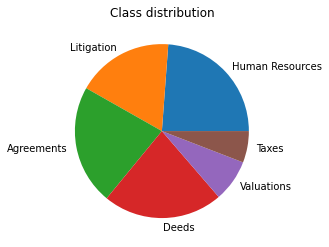

In [354]:
### showing class imbalances
data = pd.DataFrame(data)
x= list(set(data["Labels/Classes"].values))
y = data.groupby(["Labels/Classes"]).size()
plt.pie(y, labels = x)
plt.title("Class distribution") 
plt.show()



In [9]:
### generating corpus by joining list of lists representing individual documents

corpus = ["".join(i) for i in FullText]
#str(i).replace("\t","") for i in corpus
len(corpus)

256

### Using the package Stanza for text pre-processing, (includes pos tagging, tokenization and lemmatization)

In [2]:
### downloading pretrained model for english language in the stanza library
stanza.download('en')


2020-12-27 17:53:48 INFO: Downloading default packages for language: en (English)...
2020-12-27 17:54:01 INFO: File exists: /root/stanza_resources/en/default.zip.
2020-12-27 17:54:06 INFO: Finished downloading models and saved to /root/stanza_resources.


In [3]:
### building stanza preprocessing pipeline 
  ###1. POS tagging and parsing
  ###2. Tokenizing and Lemmatizing
nlp = stanza.Pipeline('en',processors='pos,tokenize,lemma')

2020-12-27 17:54:13 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |

2020-12-27 17:54:13 INFO: Use device: gpu
2020-12-27 17:54:13 INFO: Loading: tokenize
2020-12-27 17:54:23 INFO: Loading: pos
2020-12-27 17:54:24 INFO: Loading: lemma
2020-12-27 17:54:24 INFO: Done loading processors!


#### To access saved file containing the pre-processed tokens (in order to save computation time)

In [ ]:
### please uncomment the code and use it to load the file that has the pre-processed tokens
### in order to save computation time 
### you will have to upload the file first to your colab directory
'''with open("/content/doc_wise_tokens_total.pkl",'rb') as f:
  doc_wise_tokens = pickle.load(f)'''

#### pre-processing contd..

In [ ]:
### Preprocessing doc with size less than 140000 words

tok_lemma_pos = []
skipped_ids = []
for i in range(0,len(corpus)):
  if(len(corpus[i]) < 140000):
    print(i)
    tok_lemma_pos.append(nlp(corpus[i]))
  else:
    skipped_ids.append(i)

In [15]:
### generating the target variable as per the sequence of preprocessing on
### documents which were processed in previous step

labels = data['Labels/Classes']
target = [labels[i] for i in range(0,len(corpus)) if i not in skipped_ids ]


253

In [ ]:
### pre processing the skipped documents separately because of computational 
### limitation. 3 documents couldnt get pre processed because of very high volume

tok_lemma_pos_2 = []

for i in skipped_ids:
  if((i!=63)&(i!=101) &(i!=102)):
    print(i)
    tok_lemma_pos_2.append(nlp(corpus[i]))
### generating the target variable as per the sequence of preprocessing on
### documents which were not processed in previous step  

[target.append(labels[i]) for i in skipped_ids if (i != 63) and (i!=101) and (i!=102)]


186
187
188
189
190
191
193
194
230
244


### Data Preparation for Word2Vec

In [ ]:
### filtering tokens on POS tags
### this also does stopword removal because here such tokens are given POS tags that are not considered
def filtered_words(tok_lemma_pos_2):
  filtered_words_doc = []
  filtered_words_sent = []
  temp = []
  for doc in tok_lemma_pos_2:
    for sentence in doc.sentences:
        for word in sentence.words:
            if((word.pos == "VERB") | (word.pos == "NOUN") | (word.pos == "ADV") | (word.pos == "ADJ") ):
              if(len(word.lemma) > 2):
                temp.append(word.lemma)
              #print(word.text, word.lemma, word.pos)
        #print(temp)
        filtered_words_sent.append(temp)
        temp = []
        #print(filtered_words_sent)
    filtered_words_doc.append(filtered_words_sent)
    filtered_words_sent=[]
    #print(filtered_words_doc)
### converting to document level tokenization
  doc_wise_tokens_2 = []
  for k in range(0,len(filtered_words_doc)):
    doc_wise_tokens_2.append([i for j in filtered_words_doc[k] for i in j])
  return doc_wise_tokens_2
  


PUNCT


In [ ]:
### appending the lists of document level tokens ##
doc_wise_tokens = filtered_words(tok_lemma_pos)
doc_wise_tokens_1 = filtered_words(tok_lemma_pos_2)
[doc_wise_tokens.append(i) for i in doc_wise_tokens_1]



In [17]:
'''import pickle
with open('/root/doc_wise_tok_1.pkl', 'wb') as f:
  pickle.dump(doc_wise_tokens_1, f)
with open('/root/target.pkl', 'wb') as f:
  pickle.dump(target, f)'''

In [16]:

'''with open('/content/doc_wise_tokens_total.pkl','rb') as f:
  doc_wise_tokens = pickle.load(f)'''

### Some visualizations to get an overview of the data 

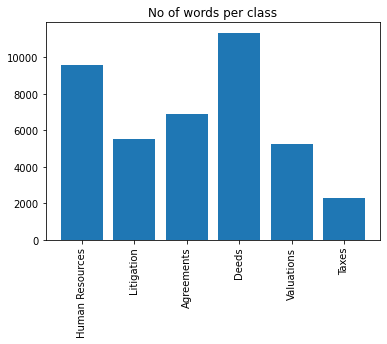

In [350]:
#### generating class wise word counts ###
def generate_word_counts (doc_wise_tokens,target):
  data_for_class_based_words = pd.DataFrame(columns=['words','class'])
  data_for_class_based_words['words'] = doc_wise_tokens
  data_for_class_based_words['class'] = target
  data_for_class_based_words.groupby('class')['words']
  labels = list(set(target))
  length = dict()
  for i in labels:
    words = data_for_class_based_words[data_for_class_based_words['class']==i]['words']
    length.update({i:len(set(["".join(i) for j in words for i in j]))})
  return length
word_counts = generate_word_counts(doc_wise_tokens,target)
plt.bar(word_counts.keys(),word_counts.values())
plt.xticks(rotation=90)
plt.title("No of words per class")
plt.show()

In [ ]:
### Generating word clouds for classes - HR, Agreements, Taxes
data_for_class_based_words = pd.DataFrame(columns=['words','class'])
data_for_class_based_words['words'] = doc_wise_tokens
data_for_class_based_words['class'] = target



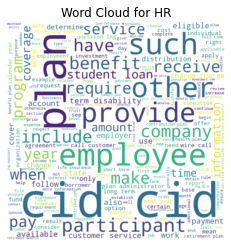

In [333]:

words_hr = data_for_class_based_words[data_for_class_based_words['class']=='Human Resources']['words']
words_hr = ["".join(i) for j in words_hr for i in j]
words_hr = " ".join(words_hr)

wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = ['\\xa0','\\\\u2002'],
               min_font_size = 10).generate(words_hr)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for HR")
plt.show()



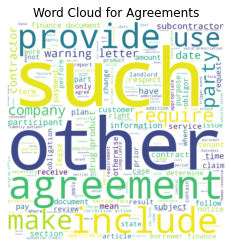

In [349]:
words_ag = data_for_class_based_words[data_for_class_based_words['class']=='Agreements']['words']
words_ag = ["".join(i) for j in words_ag for i in j]
words_ag = " ".join(words_ag)

wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = ['\\\\xa0','\\\\u2002','xa0'],
               min_font_size = 10).generate(words_ag)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Agreements")
plt.show()

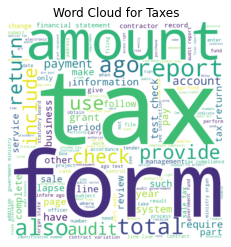

In [335]:
words_taxes = data_for_class_based_words[data_for_class_based_words['class']=='Taxes']['words']
words_taxes = ["".join(i) for j in words_taxes for i in j]
words_taxes = " ".join(words_taxes)

wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = ['\\xa0','\\\\u2002'],
                min_font_size = 10).generate(words_taxes)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Taxes")
plt.show()


###Word2Vec was trained on the custom corpus as well, but since the pre-trained model on Google News corpus gave better accuracy, I moved ahead with it**

In [168]:
### word2vec model initialized
w2v_model = Word2Vec(size=300,window=5,min_count=5,negative=15)

In [169]:
### w2v model building vocab based on tokens of our corpus

from time import time
t = time()
w2v_model.build_vocab(doc_wise_tokens)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))                     
t = time()

Time to build vocab: 0.02 mins


In [170]:
w2v_model.corpus_total_words
len(w2v_model.wv.vocab)

6657

In [171]:

w2v_model.train(doc_wise_tokens, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)
#w2v_model.wv.save_word2vec_format("/root/word2vec.model")

(3094572, 5265500)

In [144]:
### plot TSNE of self trained w2v models where the window size has been reduced
### and minimum word count has been increased for demonstrational purposes

from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


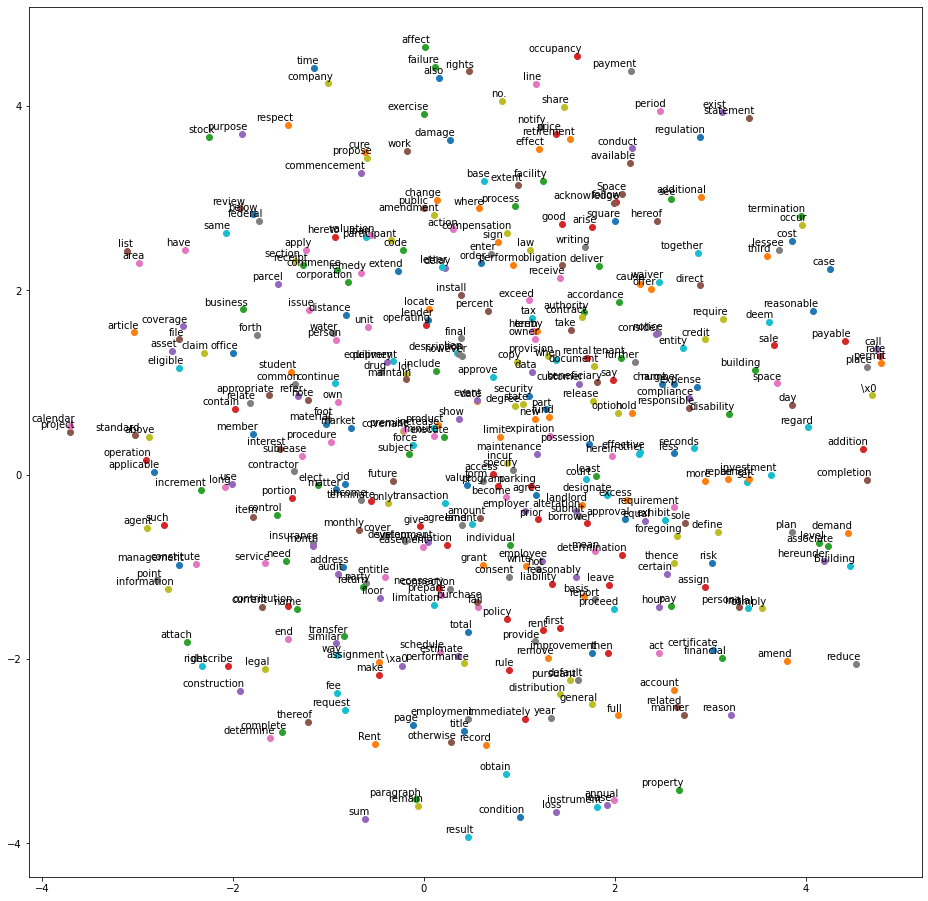

In [164]:
### plot of word2vec teained on custom corpus (this has been trained on less data
### for visualization purposes, using tsne 
tsne_plot(w2v_model)

In [19]:
### loading the pretrained w2v model on google news corpus with 300 embeddings
nlp1 = gensim_api.load("word2vec-google-news-300")


In [21]:
### Generating the final feature matrix depending on the similar tokens between
### custom corpus and w2v model vocab ####

words = [i for j in doc_wise_tokens for i in j]
unique_words = set(words)
#vec_list = [w2v_model[word] for word in unique_words if word in w2v_model.wv.vocab]
vec_list = [nlp1[word] for word in unique_words if word in nlp1.wv.vocab]
#word_list = [word for word in unique_words if word in w2v_model.wv.vocab]
word_list = [word for word in unique_words if word in nlp1.wv.vocab]
### zipping the words and the vectors #####
word_vec_list = zip(word_list,vec_list)
## converting to a dictionary to finally form a dataframe ##
word_vec_list = dict(word_vec_list)
embedding_matrix = pd.DataFrame.from_dict(word_vec_list,orient='index')
### taking the row-wise mean of the dataframe to find the embeddings for every document ##
word_wise_mean = embedding_matrix.mean(axis=1)
word_wise_mean = word_wise_mean.to_dict()
#[i for i in word_wise_mean.index if i in doc_wise_tokens[]]
x = []
for j in range(0,len(doc_wise_tokens)):
  x.append([word_wise_mean[i]  if i in doc_wise_tokens[j] else 0 for i in word_wise_mean.keys()])
feature_matrix = pd.DataFrame(data = x, columns=word_wise_mean.keys(), index = range(0,len(doc_wise_tokens)))
#feature_matrix = feature_matrix.fillna(0)
feature_matrix['Target'] = target
feature_matrix.columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Index(['spendthrift', 'amplifier', 'typical', 'playing', 'range', 'Chief',
       'escrow', 'laxity', 'cable', 'tungsten',
       ...
       'station', 'definition', 'command', 'ofmore', 'irrevocably', 'apr',
       'import', 'cope', 'damper', 'Target'],
      dtype='object', length=11984)

### Performed Sampling to reduce class imbalances, using SMOTE

In [432]:
### train-test split on the sampled data 
X = feature_matrix.iloc[:,:-1]
Y = feature_matrix.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split( X_smote,  y_smote, test_size = 0.25)
smote = SMOTE(random_state=777,k_neighbors=5)
X_smote,y_smote = smote.fit_sample(X_train,Y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

#### Pie chart shows that class imbalances problem has been reduced after sampling using SMOTE

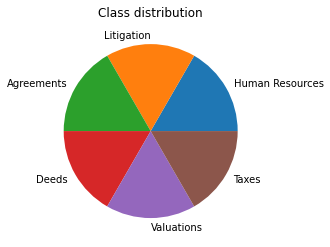

In [403]:
df_smote = pd.DataFrame(columns = ['y'])
df_smote['y'] = y_smote
x= list(set(df_smote["y"].values))
y = df_smote.groupby(["y"]).size()
plt.pie(y, labels = x)
plt.title("Class distribution") 
plt.show()

In [30]:
### for saving the generated feature matrix and target variable
'''with open("/root/X_smote.pkl",'wb') as f:
  pickle.dump(X_smote,f)
with open("/root/Y_smote.pkl",'wb') as f:
  pickle.dump(y_smote,f)
with open("/root/feature_mat.pkl",'wb') as f:
  pickle.dump(feature_matrix,f)'''



In [398]:
### to provide customized class weights, however after sampling the 
### effect for this becomes negligible

catCount= pd.DataFrame(columns = ['Target'])
catCount['Target'] = Y_train

catCount= catCount.groupby(["Target"]).size()

categories= pd.Series(catCount.index)

catSum = catCount.sum()


catPercent= []##### Calculating sample weights in the train data
for item in catCount:
    catPercent.append(item/catSum)

catWeights= pd.Series(1/(np.array(catPercent)*10))
catWeights.index = categories 

catWeights.index = categories 
catWeights= catWeights.to_dict()

catWeights

{'Agreements': 0.6088888888888889,
 'Deeds': 0.5956521739130435,
 'Human Resources': 0.548,
 'Litigation': 0.6682926829268292,
 'Taxes': 0.6227272727272727,
 'Valuations': 0.5708333333333333}

### Trying out various models on Word2Vec feature matrix for getting the model with the best performance




In [386]:
### Finding different model's perforances using CV on word2vec feature matrix

models = [RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=10,
                                 random_state = 0,
                                 class_weight = catWeights),
          GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01,
                                     min_samples_split = 10,max_features='sqrt',
                                     max_depth = 5),
          LinearSVC(), LogisticRegression(random_state=0,solver='saga',class_weight=catWeights)]
CV = 5
cv_df = pd.DataFrame(index = range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model,X_smote,y_smote,scoring = 'accuracy', cv= CV)
  for fold_idx,accuracy in enumerate(accuracies):
    entries.append((model_name,fold_idx,accuracy))
cv_df = pd.DataFrame(entries,columns=['model_name','fold_idx','accuracy'])


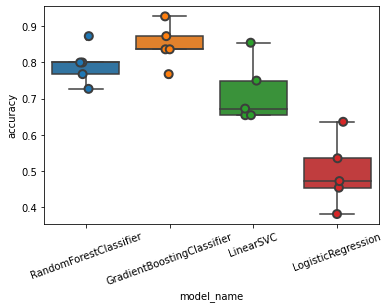

In [387]:
### plot representing performances of various models on word2vec features
sns.boxplot(x='model_name',y='accuracy',data=cv_df)
sns.stripplot(x='model_name',y='accuracy',data=cv_df,size=8,
              jitter=True,edgecolor='gray',
              linewidth=2)

plt.xticks(rotation=20)
plt.show()

###GridSearchCV for hyperparameter tuning for RandomForest

In [452]:
### CV grid search for random forest to find best hyperparameters

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)
rdf = RandomForestClassifier(random_state = 1,bootstrap=True,class_weight=catWeights) 
scoring = {'accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }
params = {'max_depth': [2,5,10], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf' : [2,5,10],
              'n_estimators' : [200,500,1000]
             }


grid_clf = GridSearchCV(estimator = rdf, param_grid = params,scoring='accuracy', cv = cv, n_jobs=-1, verbose=20)

grid_clf.fit(X_smote, y_smote)
Y_pred = grid_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print(grid_clf.score)
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Accuracy: 0.8533333333333334
<bound method BaseSearchCV.score of GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={'Agreements': 0.6088888888888889,
                                                            'Deeds': 0.5956521739130435,
                                                            'Human Resources': 0.548,
                                                            'Litigation': 0.6682926829268292,
                                                            'Taxes': 0.6227272727272727,
                                                            'Valuations': 0.5708333333333333},
                                              criterion='g...
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jo

In [454]:
### initializing random forest on the best hyperparameters 

#rf = RandomForestClassifier(max_depth =  10, min_samples_leaf= 2, min_samples_split= 5, n_estimators= 500,class_weight=catWeights)

rf1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={'Agreements': 0.6088888888888889,
                                     'Deeds': 0.5956521739130435,
                                     'Human Resources': 0.548,
                                     'Litigation': 0.6682926829268292,
                                     'Taxes': 0.6227272727272727,
                                     'Valuations': 0.5708333333333333},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


##### We find that Random Forest performs with best accuracy of 85% approximately on Word2Vec feature matrix

In [456]:
rf1.fit(X_smote,y_smote)
rf1.score(X_test,Y_test)
#rf.predict(X_test)

0.8533333333333334

### GridSearchCV for finding the best parameters for GradientBoosting Classifier

In [405]:
### CV grid search for gradient boost to find best hyperparameters

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)
gbt = GradientBoostingClassifier(random_state = 1) 
scoring = {'accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }
params = {'max_depth': [2,5,10], 
              'min_samples_split': [2,5],
              'max_features':['sqrt'],
              'learning_rate' : [0.01,0.1],
              'n_estimators' : [200,500,750] }


grid_clf_gb = GridSearchCV(estimator = gbt, param_grid = params,
                           scoring='accuracy',
                           cv = cv, n_jobs=-1, 
                           verbose=20)

grid_clf_gb.fit(X_smote, y_smote)
Y_pred = grid_clf_gb.predict(X_test)


print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print(grid_clf_gb.score(X_test,Y_test))
print(grid_clf_gb.best_estimator_)
print(grid_clf_gb.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Accuracy: 0.8586956521739131
0.8586956521739131
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=2,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
{'learning_rate': 0.01, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}


##### We find that Gradient Boost model performs with best accuracy of 86% approximately on Word2Vec feature matrix

In [466]:
### initializing gradient boost with the best hyperparameters

gb1= GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=2,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

gb1.fit(X_smote,y_smote)
gb1.score(X_test,Y_test)

0.8666666666666667

##### Showing the output of the best model which is Gradient Boosting classifier trained on Word2vec feature matrix with 86% accuracy

In [408]:
### showing the output of model with best accuracy 
df_check = pd.DataFrame(columns=['Actual','Predict'])
df_check['Actual'] = Y_test
df_check['Predict'] = gb1.predict(X_test)
df_check

,Actual,Predict
0,Litigation,Litigation
1,Valuations,Valuations
2,Valuations,Valuations
3,Taxes,Taxes
4,Litigation,Litigation
...,...,...
87,Taxes,Taxes
88,Taxes,Taxes
89,Human Resources,Agreements
90,Litigation,Litigation


In [ ]:
###saving model rf
'''with open("/root/rf_model_grid_80_accuracy.pkl",'wb') as f:
  pickle.dump(grid_clf,f)'''

In [97]:
### saving model...
'''with open("/root/gbmodel_90_grid_accuracy.pkl",'wb') as f:
  pickle.dump(gb,f)'''

### TF-IDF Vectorizer was also tried, but it failed to generate as good results as the Word2Vec feature vector

In [425]:
### self defined function  to pass as a tokenizer and preprocessor to tfidf , 
### because the documents are already tokenized and preprocessed
def dummy_tok(doc):
  return doc
with open("/content/doc_wise_tokens_total.pkl",'rb') as f:
  doc_wise_tokens = pickle.load(f)
tf_idf = TfidfVectorizer(analyzer='word',
                         norm = 'l2' , sublinear_tf = False,
                         tokenizer = dummy_tok,
                         preprocessor = dummy_tok)
### generating feature matrix for tfidf
feature_tfidf = tf_idf.fit_transform(doc_wise_tokens).toarray()

In [434]:
### Smote for TFIDF feature matrix
X = feature_tfidf[:,:-1]
Y = target
smote1 = SMOTE(random_state=123,k_neighbors=5)

X_tr,X_te,Y_tr,Y_te = train_test_split(X,Y,test_size=0.25)

X_smote_tfidf ,Y_smote_tfidf = smote1.fit_sample(X_tr,Y_tr)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [437]:
### Finding different model's perforances using CV on tfidf feature matrix

models1 = [RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=10,
                                 random_state = 0,
                                 class_weight = catWeights),
          GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01,
                                     min_samples_split = 10,max_features='sqrt',
                                     max_depth = 5),
           MultinomialNB(),
          LinearSVC(), LogisticRegression(random_state=0,solver='saga',class_weight=catWeights)]
CV = 5
cv_df1 = pd.DataFrame(index = range(CV * len(models1)))
entries1 = []
for model in models1:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model,X_smote_tfidf,Y_smote_tfidf,scoring = 'accuracy', cv= CV)
  for fold_idx,accuracy in enumerate(accuracies):
    entries1.append((model_name,fold_idx,accuracy))
cv_df1 = pd.DataFrame(entries1,columns=['model_name','fold_idx','accuracy'])


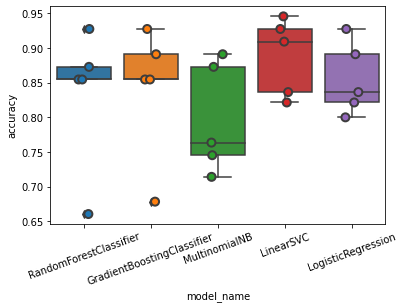

In [439]:
sns.boxplot(x='model_name',y='accuracy',data=cv_df1)
sns.stripplot(x='model_name',y='accuracy',data=cv_df1,size=8,
              jitter=True,edgecolor='gray',
              linewidth=2)

plt.xticks(rotation=20)
plt.show()

In [442]:
SVC_Classifier = LinearSVC()
SVC_Classifier.fit(X_smote_tfidf,Y_smote_tfidf)
SVC_Classifier.score(X_te,Y_te)

0.75

In [447]:
### Fitting Naive Bayes classifier on tfidf feature matrix
NVCLassifier = MultinomialNB()
NVCLassifier.fit(X_smote_tfidf,Y_smote_tfidf)
NVCLassifier.score(X_te,Y_te)

0.734375

In [448]:
### asssesing Random Forest on tfidf feature matrix
### CV grid search for random forest to find best hyperparameters

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)
rdf1 = RandomForestClassifier(random_state = 1,bootstrap=True,class_weight=catWeights) 
scoring = {'accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }
params = {'max_depth': [2,5,10], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf' : [2,5,10],
              'n_estimators' : [200,500,1000]
             }


grid_clf1 = GridSearchCV(estimator = rdf1, param_grid = params,scoring='accuracy', cv = cv, n_jobs=-1, verbose=20)

grid_clf1.fit(X_smote_tfidf, Y_smote_tfidf)
Y_pred = grid_clf1.predict(X_te)

print("Accuracy:",metrics.accuracy_score(Y_te, Y_pred))
print(grid_clf1.score)
print(grid_clf1.best_estimator_)
print(grid_clf1.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Accuracy: 0.734375
<bound method BaseSearchCV.score of GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={'Agreements': 0.6088888888888889,
                                                            'Deeds': 0.5956521739130435,
                                                            'Human Resources': 0.548,
                                                            'Litigation': 0.6682926829268292,
                                                            'Taxes': 0.6227272727272727,
                                                            'Valuations': 0.5708333333333333},
                                              criterion='g...
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
 

In [449]:
rf_cv= RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={'Agreements': 0.6088888888888889,
                                     'Deeds': 0.5956521739130435,
                                     'Human Resources': 0.548,
                                     'Litigation': 0.6682926829268292,
                                     'Taxes': 0.6227272727272727,
                                     'Valuations': 0.5708333333333333},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
rf_cv.fit(X_smote_tfidf,Y_smote_tfidf)
rf_cv.score(X_te,Y_te)

0.734375

In [ ]:
### CV grid search for gradient boost to find best hyperparameters

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)
gbt_t = GradientBoostingClassifier(random_state = 1) 
scoring = {'accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }
params = {'max_depth': [2,5,10], 
              'min_samples_split': [2,5],
              'max_features':['sqrt'],
              'learning_rate' : [0.01,0.1],
              'n_estimators' : [200,500,750] }


grid_clf_gb_t = GridSearchCV(estimator = gbt_t, param_grid = params,
                           scoring='accuracy',
                           cv = cv, n_jobs=-1, 
                           verbose=20)

grid_clf_gb_t.fit(X_smote_tfidf, Y_smote_tfidf)
Y_pred = grid_clf_gb_t.predict(X_te)


print("Accuracy:",metrics.accuracy_score(Y_te, Y_pred))
print(grid_clf_gb_t.score(X_te,Y_te))
print(grid_clf_gb_t.best_estimator_)
print(grid_clf_gb_t.best_params_)

In [451]:
### Fitting gradient boosting on tfidf feature matrix
Y_pred = grid_clf_gb_t.predict(X_te)

print("Accuracy:",metrics.accuracy_score(Y_te, Y_pred))
print(grid_clf_gb_t.score(X_te,Y_te))
print(grid_clf_gb_t.best_estimator_)
print(grid_clf_gb_t.best_params_)

Accuracy: 0.796875
0.796875
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500}


### Model Performance Vizualisations for the models trained on Word2Vec features 

In [461]:
### binarizing classes and finding unique classes to get multiclass precision 
### recall for word2vec feature matrix
Y_test_1 = np.reshape(Y_test,(1,Y_test.size))
x = Y_test_1.tolist()
unique_classes = [set(i) for i in x]

'''with open("/rf_model_grid_80_accuracy.pkl",'rb') as f:
  rf_model_80 = pickle.load(f)'''


y_score = rf1.predict(X_test)
classes=[i for i in unique_classes[0]]
y_score_1 = label_binarize(y_score,classes=[i for i in unique_classes[0]])

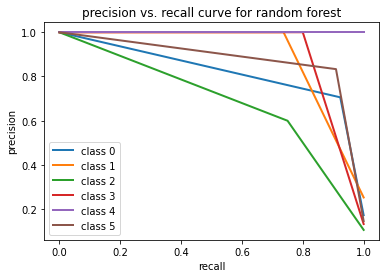

In [462]:
### plotting precision recall for Random Forest model with 80% accuracy
### for word2vec feature matrix
y_test = label_binarize(Y_test,classes=[i for i in unique_classes[0]])
precision = dict()
recall = dict()
for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score_1[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve for random forest")
plt.show()


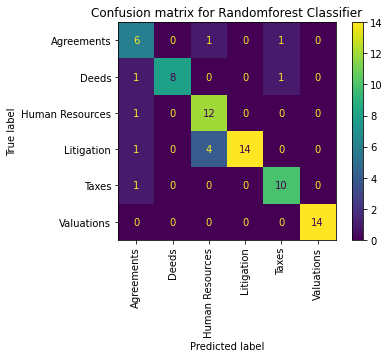

In [463]:
### plotting confusion matrix for Random Forest model
### for word2vec feature matrix
plot_confusion_matrix(rf1, X_test, Y_test)  
plt.xticks(rotation=90)
plt.title("Confusion matrix for Randomforest Classifier")
plt.show()

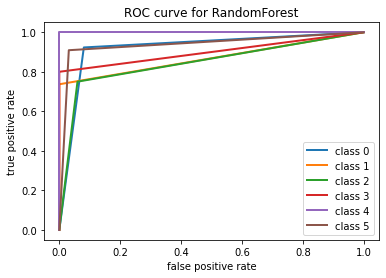

In [464]:
###  plotting roc curve for Random Forest model
### for word2vec feature matrix
fpr = dict()
tpr = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_score_1[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve for RandomForest")
plt.show()

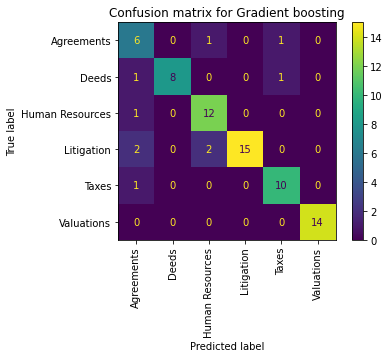

In [467]:
### plotting confusion matrix for Gradient Boosting model
### for word2vec feature matrix


plot_confusion_matrix(gb1, X_test, Y_test)  
plt.xticks(rotation=90)
plt.title("Confusion matrix for Gradient boosting")
plt.show()


In [468]:
### binarizing output of model gradient boosting
y_score_gb = gb1.predict(X_test)
y_score_gb = label_binarize(y_score_gb,classes=[i for i in unique_classes[0]])


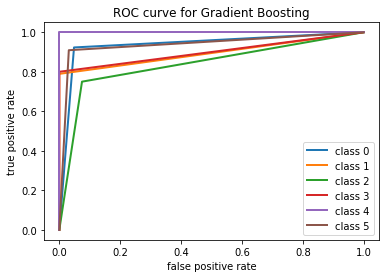

In [469]:
###  plotting roc curve for gradient boosting model
### for word2vec feature matrix
fpr = dict()
tpr = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_score_gb[:, i]
                                  )
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve for Gradient Boosting")
plt.show()

###Conclusion - We find that the Gradient Boosting classifier has performed the best in this multiclass text classification task, with feature matrix that was generated from the word2vec model. The highest accuracy was 86%, followed by Randomforest which has the best accuracy of 85%. For Tf-IDF feature vector, almost all models tried, have similar accuracies, so we might consider it to be 75% on an average